In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io

# general libraries
import os  
import sys
import json
import time
import h5py as h5
from functools import partial

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf
from scalebars import *
import deconv

# import balance_configs as configs
import sac_mode_configs as configs
import experiments as exps
import analysis as ana
sys.path.append('../imaging-utils')
from image_arrays import map_axis

In [2]:
# %matplotlib notebook
%matplotlib widget
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

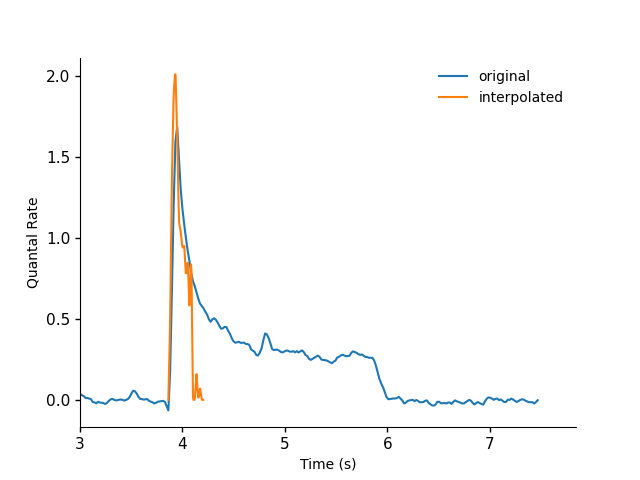

In [3]:
quanta_h5 = "/mnt/Data/prerna_velocity/static_roi_waveforms/quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]
rec_dt = quantum_pack["rec_dt"]
# target_rate_dt = 0.001  # 0.0001
target_rate_dt = 0.005  # 0.0001
bp_inputs = {("sust" if k == "PD" else "trans"): r for k, r in quantum_pack["aligned_recs"].items()}
bp_inputs["sust"] = bp_inputs["sust"] * np.max(bp_inputs["trans"]) / np.max(bp_inputs["sust"])

vrate = deconv.velocity_rate(
    bp_inputs["trans"],
    rec_dt,
    quantum_pack["quantum"],
    1,
    rf=0.06,
    spot=0.2,
    bsln_start=100,
    bsln_end=150,
    step=1,
    offset=0.,
    model_dt=target_rate_dt,
)
vrate = np.clip(vrate, 0.0, np.inf)

trans_rise = find_rise_bsln(bp_inputs["trans"], bsln_start=100, bsln_end=150, step=1) * rec_dt
rate_fig, rate_ax = plt.subplots(1)
rate_ax.plot(np.arange(len(bp_inputs["trans"])) * rec_dt, bp_inputs["trans"], label="original")
rate_ax.plot(np.arange(len(vrate)) * target_rate_dt + trans_rise, vrate, label="interpolated")
rate_ax.set_xlim(3)
rate_ax.set_xlabel("Time (s)")
rate_ax.set_ylabel("Quantal Rate")
rate_ax.legend(frameon=False)
clean_axes(rate_ax)

In [4]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"
model_path = os.path.join(base_path, "vc_runs/")
fig_dir_path = os.path.join(model_path, "figs") 
save_name = "test"
load_name = None
# load_name = "exp_poisson_control_54decay"
# load_name = "exp_poisson_plex3_share0p5_54decay"
# load_name = "old_conf_test"
# load_name = "ctrl_5ms_step_weight_x2_order2"
# load_name = "ctrl_5ms_step_weight_x2_order2_5tr"
# save_name = "plex3_5ms_step_weight_x2_order2_5tr"
load_name = "ctrl_5ms_step_weight_x2_order2_5tr_rho_range"
# load_name = "ctrl_5ms_step_weight_x2_order2_5tr_rho_range_0p5tmrho"
# load_name = "ctrl_5ms_step_weight_x2_order2_5tr_rho_range_0p0tmrho"

# model_config = configs.conf(
model_config = configs.decr_weight(
# model_config = configs.alt_conf(
    vc_mode=True,
    non_ds_ach=False,
    offset_ampa_ach=False,
    # poisson_rates={"sac": vrate * 1., "glut": vrate * 1., "dt": target_rate_dt},
    poisson_rates={"sac": vrate * 0.5, "glut": vrate * 1., "dt": target_rate_dt},
    plexus=0,
    plexus_share=None,
)

model_config["synprops"]["E"]["weight"] = model_config["synprops"]["E"]["weight"]       * 2 #* 2
model_config["synprops"]["PLEX"]["weight"] = model_config["synprops"]["PLEX"]["weight"] * 2 #* 2
model_config["synprops"]["I"]["weight"] = model_config["synprops"]["I"]["weight"]       * 2 #* 2
model_config["synprops"]["E"]["tau2"] = 0.54
model_config["synprops"]["PLEX"]["tau2"] = 0.54

model_config["first_order"] = 2

# model_config["time_rho"] = 0.

if load_name is None:
    from ei_balance_nogui import *
    os.makedirs(model_path, exist_ok=True)
    save_path = os.path.join(model_path, save_name) + ".h5"
    load_name = save_name
    exps.sacnet_run(
        save_path,
        model_config,
        n_nets=6,
        n_trials=5,
        rho_steps=[0.0, 1.0],
        # rho_steps=[0.0, 0.8, 0.9, 0.96, 0.98, 0.99, 1.0],
        pool_sz=6,
        vc_mode=True,
    )

t0 = time.time()
with h5.File(os.path.join(model_path, load_name) + ".h5", "r") as pckg:
    d = unpack_hdf(pckg)
print("data unpacked in %.1fs" % (time.time() - t0))
fig_path = os.path.join(fig_dir_path, load_name)
os.makedirs(fig_path, exist_ok=True)
        
rhos = list(d.keys())
idxs = list(d[rhos[0]].keys())
exp_keys = list(d[rhos[0]][idxs[0]].keys())
transmitters = list(d[rhos[0]][idxs[0]]["soma"].keys())
print("==keys==")
print("rhos:", rhos)
print("idxs:", idxs)
print("exp keys:", exp_keys)
print("rec keys:", transmitters)
print("rec shape:", d[rhos[0]][idxs[0]]["soma"]["E"].shape)

sac net trials 1 to 6 (of 6)...
Done!
data unpacked in 37.5s
==keys==
rhos: [1.0, 0.0]
idxs: [5, 4, 3, 2, 1, 0]
exp keys: ['syn_locs', 'soma', 'sac_net', 'params']
rec keys: ['GABA', 'E', 'AMPA', 'ACH']
rec shape: (5, 8, 7501)


In [5]:
params = d[0.0][0]["params"]
dir_labels = params["dir_labels"]
null_idx = np.argwhere(dir_labels == 180)[0][0]
pref_idx = np.argwhere(dir_labels == 0)[0][0]
xaxis = np.arange(int(params["tstop"] / params["dt"]) + 1) * params["dt"]

In [6]:
vc_trial_avgs = {
    rho: {
        n: {trans: np.mean(rec, axis=0) for trans, rec in net["soma"].items()}
        for n, net in nets.items()
    }
    for rho, nets in d.items()      
}
    
vc_net_avgs = {
    rho: {
        trans: np.mean([net[trans] for net in nets.values()], axis=0)
        for trans in transmitters
    }
    for rho, nets in vc_trial_avgs.items()
}

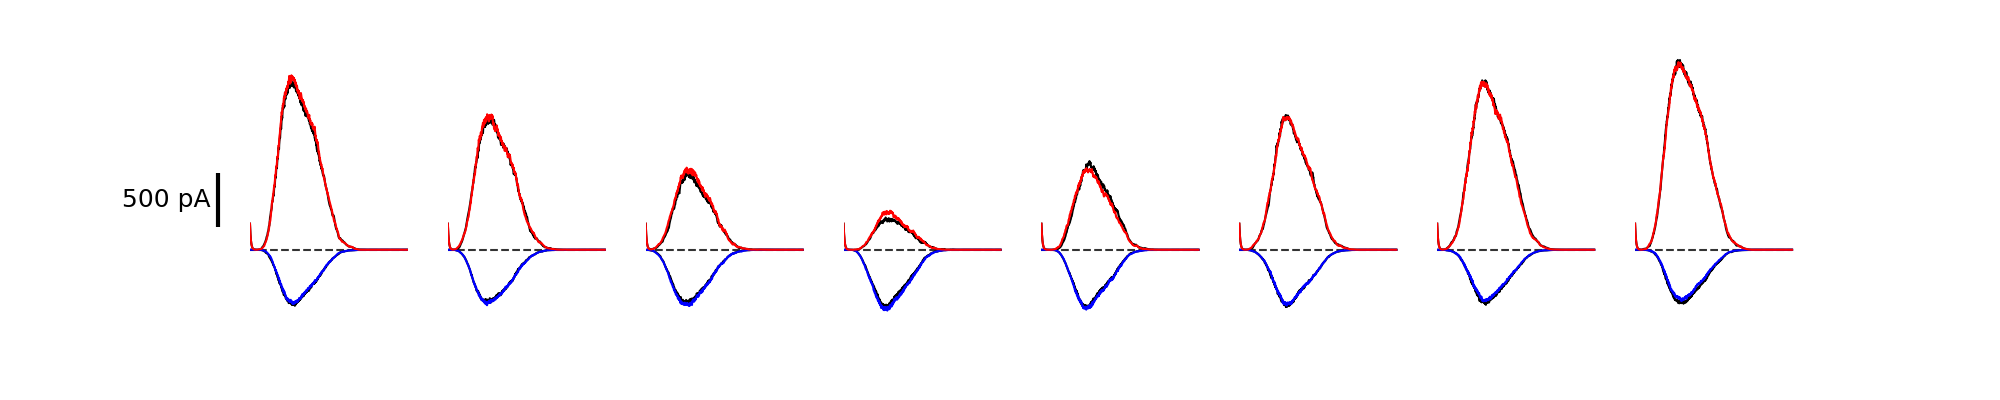

In [7]:
incl_rho0 = True
net_avg_fig, net_avg_ax = plt.subplots(
    1, len(dir_labels), sharex=True, sharey="row", figsize=(20, 4))

for i, ax in enumerate(net_avg_ax):
    ax.plot([xaxis[0], xaxis[-1]], [0., 0.], c="black", linestyle="--", alpha=0.8)
    if incl_rho0:
        ax.plot(xaxis, vc_net_avgs[0.0]["E"][i], c="black")
        ax.plot(xaxis, vc_net_avgs[0.0]["GABA"][i], c="black")
    ax.plot(xaxis, vc_net_avgs[1.0]["E"][i], c="blue")
    ax.plot(xaxis, vc_net_avgs[1.0]["GABA"][i], c="red")

clean_axes(net_avg_ax, remove_spines=["left", "right", "top", "bottom"])

add_scalebar(
    net_avg_ax[0], 
    matchx=False, 
    matchy=False, 
    # sizey=1.5, 
    # labely="1.5 nA",
    sizey=0.5, 
    labely="500 pA",
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(170, 200),
    textprops={"fontsize": 18},
)

# net_avg_ax[-1].set_ylim(-2, 4)
net_avg_ax[-1].set_ylim(-1, 1.9)
# net_avg_ax[-1].set_ylim(-2, 6)
# net_avg_ax[-1].set_xlim(10, 300)
net_avg_ax[-1].set_xlim(10)
name = os.path.join(fig_path, "net_avg_ach_gaba%s.svg" % ("_w_rho0" if incl_rho0 else ""))
net_avg_fig.savefig(name)

In [8]:
upward_e_avgs = vc_net_avgs[1.00]["E"] * -1
time_offsets = np.array([
    find_rise_bsln(d, bsln_start=0, bsln_end=1, offset=0.03, step=1)
    for d in upward_e_avgs
]) * params["dt"]
align_offsets = np.max(time_offsets) - time_offsets

print("E field offsets (ms):", time_offsets)
print("alignment_shifts (ms):", align_offsets)

E field offsets (ms): [ 92.5  71.6  58.8  78.2  95.9  90.4  94.4 101.6]
alignment_shifts (ms): [ 9.1 30.  42.8 23.4  5.7 11.2  7.2  0. ]


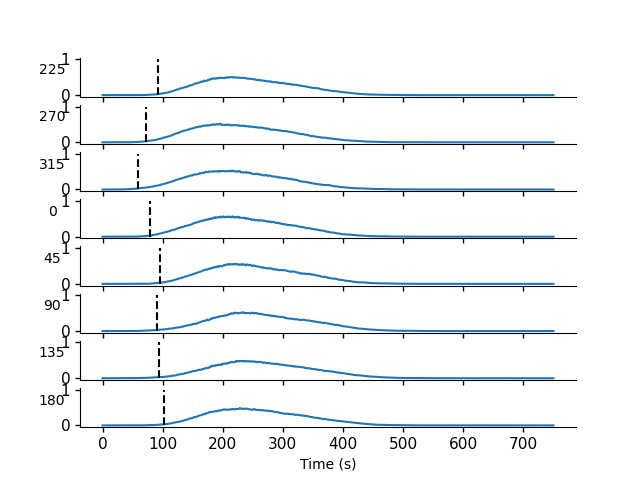

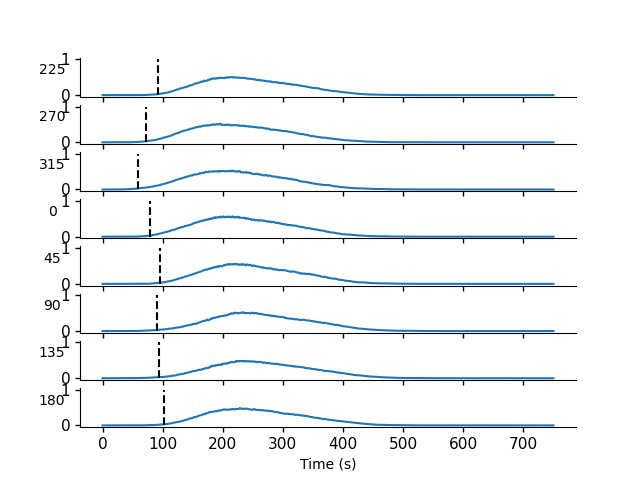

In [9]:
rf_offset_fig, rf_offset_ax = plt.subplots(8)
for ax, dr, avg, off in zip(rf_offset_ax, dir_labels, upward_e_avgs, time_offsets):
    ax.plot(xaxis, avg)
    ax.plot([off, off], [0, 1], linestyle="--", c="black")
    ax.set_ylabel(dr, rotation="horizontal", labelpad=6., position=(1, 0.3))
    
clean_axes(rf_offset_ax)
rf_offset_ax[-1].set_xlabel("Time (s)")
rf_offset_fig.show()

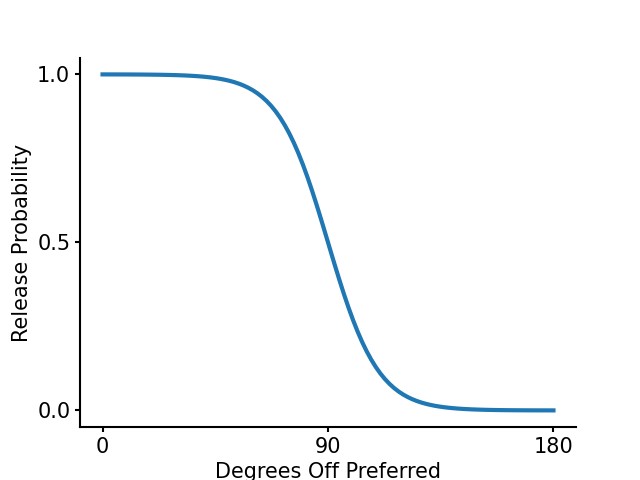

In [10]:
def sigmoid (d, n, p, offset=90, slope=0.075): 
    return p + (n - p) * (1 - 1 / (1 + np.exp((d - offset) * slope)))

# null_pr = 0.05
# pref_pr = 0.95
null_pr = 0.0
pref_pr = 1.0

dir_range = np.linspace(0, 180, 100) 
prob_p1 = np.squeeze(sigmoid(dir_range, null_pr, pref_pr, offset=90, slope=0.1))
prob_p075 = np.squeeze(sigmoid(dir_range, null_pr, pref_pr))
prob_p05 = np.squeeze(sigmoid(dir_range, null_pr, pref_pr, slope=null_pr))

sigmoid_fig, sigmoid_ax = plt.subplots(1)
sigmoid_ax.plot(dir_range, prob_p1, linewidth=3, label="slope 0.1")
# sigmoid_ax.plot(dir_range, prob_p075, linewidth=3, label="slope 0.075")
# sigmoid_ax.plot(dir_range, prob_p05, linewidth=3, label="slope 0.05")
sigmoid_ax.set_ylabel("Release Probability", fontsize=15)
sigmoid_ax.set_xlabel("Degrees Off Preferred", fontsize=15)
sigmoid_ax.set_yticks([0, 0.5, 1])
sigmoid_ax.set_xticks([0, 90, 180])
clean_axes(sigmoid_ax, ticksize=15, spine_width=1.5)
# sigmoid_fig.legend()
sigmoid_fig.savefig(os.path.join(fig_path, "prob_sigmoid.svg"), bbox_inches="tight")

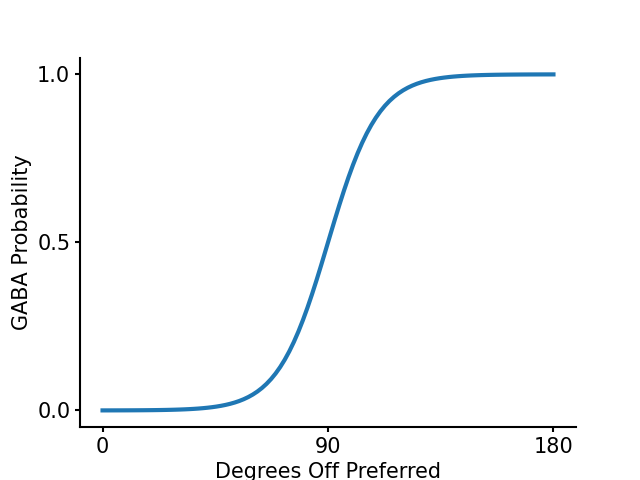

In [11]:
gaba_sigmoid_fig, gaba_sigmoid_ax = plt.subplots(1)
gaba_sigmoid_ax.plot(180 - dir_range, prob_p1, linewidth=3)
gaba_sigmoid_ax.set_ylabel("GABA Probability", fontsize=15)
gaba_sigmoid_ax.set_xlabel("Degrees Off Preferred", fontsize=15)
clean_axes(gaba_sigmoid_ax, ticksize=15)
gaba_sigmoid_ax.set_yticks([0, 0.5, 1])
gaba_sigmoid_ax.set_xticks([0, 90, 180])
clean_axes(gaba_sigmoid_ax, ticksize=15, spine_width=1.5, tick_width=1.5)
gaba_sigmoid_fig.savefig(os.path.join(fig_path, "gaba_sigmoid.svg"), bbox_inches="tight")

In [12]:
res_e = "E"
res_i = "GABA"
residuals = {
    rho: {
        net: {
            k: d[rho][net]["soma"][k] - vc_trial_avgs[rho][net][k]
            for k in [res_e, res_i] 
        }
        for net in idxs
    }
    for rho in vc_trial_avgs.keys()
}

In [13]:
# -*- coding: utf-8 -*-
# -*- mode: python -*-
# Adapted from mpl_toolkits.axes_grid1
# LICENSE: Python Software Foundation (http://docs.python.org/license.html)
# gist created by dmeliza (https://gist.github.com/dmeliza/3251476)
# TODO: adapt my own

from matplotlib.offsetbox import AnchoredOffsetbox


class AnchoredScaleBar(AnchoredOffsetbox):
    def __init__(
        self,
        transform,
        sizex=0,
        sizey=0,
        labelx=None,
        labely=None,
        pad=0,
        loc=4,
        borderpad=0.1,
        sep=2,
        xsep=None,
        ysep=None,
        prop=None,
        barcolor="black",
        barwidth=1.,
        textprops={"fontsize": 13},
        **kwargs
    ):
        """
        Draw a horizontal and/or vertical  bar with the size in data coordinate
        of the give axes. A label will be drawn underneath (center-aligned).

        - transform : the coordinate frame (typically axes.transData)
        - sizex,sizey : width of x,y bar, in data units. 0 to omit
        - labelx,labely : labels for x,y bars; None to omit
        - loc : position in containing axes
        - pad, borderpad : padding, in fraction of the legend font size (or prop)
        - sep : separation between labels and bars in points.
        - **kwargs : additional arguments passed to base class constructor
        """
        from matplotlib.patches import Rectangle
        from matplotlib.offsetbox import (
            AuxTransformBox,
            VPacker,
            HPacker,
            TextArea,
            DrawingArea,
        )

        inv = transform.inverted()  # convert display coords to axis coords
        bars = AuxTransformBox(transform)
        xbar = AuxTransformBox(transform)
        ybar = AuxTransformBox(transform)
        bar_off = (barwidth - 1)  / -2 - 1  # fudging to get butts to line up
        x_pos = inv.transform((bar_off, 0) if (sizex and sizey) else (0, 0))
        y_pos = inv.transform((0, bar_off) if (sizex and sizey) else (0, 0))

        if sizex:
            bars.add_artist(
                Rectangle(x_pos, sizex, 0, ec=barcolor, lw=barwidth, fc="none")
            )
        if sizey:
            bars.add_artist(
                Rectangle(y_pos, 0, sizey, ec=barcolor, lw=barwidth, fc="none")
            )

        if sizex and labelx:
            self.xlabel = TextArea(labelx, textprops=textprops)
            xsep = sep if xsep is None else xsep
            bars = VPacker(children=[bars, self.xlabel], align="center", pad=0, sep=xsep)
        if sizey and labely:
            self.ylabel = TextArea(labely, textprops=textprops)
            ysep = sep if ysep is None else ysep
            bars = HPacker(children=[self.ylabel, bars], align="center", pad=0, sep=ysep)

        AnchoredOffsetbox.__init__(
            self,
            loc,
            pad=pad,
            borderpad=borderpad,
            child=bars,
            prop=prop,
            frameon=False,
            **kwargs
        )


def add_scalebar(ax, matchx=True, matchy=True, hidex=True, hidey=True, **kwargs):
    """Add scalebars to axes

    Adds a set of scale bars to *ax*, matching the size to the ticks of the plot
    and optionally hiding the x and y axes

    - ax : the axis to attach ticks to
    - matchx,matchy : if True, set size of scale bars to spacing between ticks
                    if False, size should be set using sizex and sizey params
    - hidex,hidey : if True, hide x-axis and y-axis of parent
    - **kwargs : additional arguments passed to AnchoredScaleBars

    Returns created scalebar object
    """

    def f(axis):
        l = axis.get_majorticklocs()
        return len(l) > 1 and (l[1] - l[0])

    if matchx:
        kwargs["sizex"] = f(ax.xaxis)
        kwargs["labelx"] = str(kwargs["sizex"])
    if matchy:
        kwargs["sizey"] = f(ax.yaxis)
        kwargs["labely"] = str(kwargs["sizey"])

    sb = AnchoredScaleBar(ax.transData, **kwargs)
    ax.add_artist(sb)

    if hidex:
        ax.xaxis.set_visible(False)
    if hidey:
        ax.yaxis.set_visible(False)
    if hidex and hidey:
        ax.set_frame_on(False)

    return sb


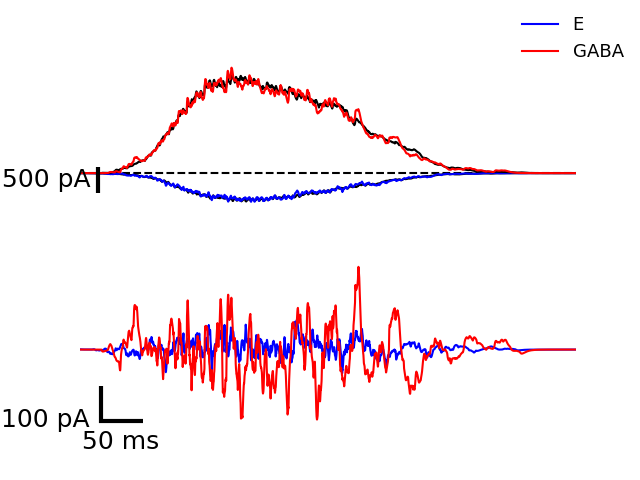

In [14]:
rho = 0.0
net = 0
trial = 0
angle = 180
normalize_resid = False
invert_i = False
scalebar_mode = True
dir_idx = np.argwhere(dir_labels == angle)[0][0]

residual_ex_fig, residual_ex_ax = plt.subplots(2, sharex=True)

residual_ex_ax[0].plot([np.min(xaxis), np.max(xaxis)], [0, 0], c="black", linestyle="--")
residual_ex_ax[0].plot(xaxis, vc_trial_avgs[rho][net][res_e][dir_idx], c="black")
residual_ex_ax[0].plot(xaxis, d[rho][net]["soma"][res_e][trial, dir_idx], c="blue", label=res_e)
residual_ex_ax[0].plot(xaxis, vc_trial_avgs[rho][net][res_i][dir_idx], c="black")
residual_ex_ax[0].plot(xaxis, d[rho][net]["soma"][res_i][trial, dir_idx], c="red", label=res_i)

ex_resid_e = residuals[rho][net][res_e][trial, dir_idx]
ex_resid_i = residuals[rho][net][res_i][trial, dir_idx]
ex_resid_i = -1 * ex_resid_i if invert_i else ex_resid_i
if normalize_resid:
    ex_resid_e = ex_resid_e / np.std(ex_resid_e)
    ex_resid_i = ex_resid_i / np.std(ex_resid_i)
residual_ex_ax[1].plot(xaxis, ex_resid_e, c="blue")
residual_ex_ax[1].plot(xaxis, ex_resid_i, c="red")

norm_prefix = "Normalized " if normalize_resid else ""
residual_ex_ax[0].set_ylim(-1, 2.2)
residual_ex_ax[-1].set_xlim(40, 600)
residual_ex_fig.legend(frameon=False, fontsize=13)

if scalebar_mode:
    vc_sb = add_scalebar(
        residual_ex_ax[0], 
        matchx=False, 
        matchy=False, 
        sizey=0.5, 
        labely="500 pA",
        sep=5,
        barwidth=3,
        loc="center",
        bbox_to_anchor=(50, 300),
        textprops={"fontsize": 18},
    )
    res_sb = add_scalebar(
        residual_ex_ax[1], 
        matchx=False, 
        matchy=False, 
        sizex=50, 
        labelx="50 ms",
        sizey=0.1, 
        labely="100 pA",
        ysep=-5,
        sep=5,
        barwidth=3,
        loc="center",
        # bbox_to_anchor=(50, 70),
        bbox_to_anchor=(80, 60),
        textprops={"fontsize": 18},
    )
    clean_axes(residual_ex_ax, remove_spines=["left", "top", "right", "bottom"])
else:
    residual_ex_ax[0].set_ylabel("Current (nA)", fontsize=14)
    residual_ex_ax[1].set_ylabel(norm_prefix + "Residual (nA)", fontsize=14)
    residual_ex_ax[-1].set_xlabel("Time (ms)", fontsize=14)
    clean_axes(residual_ex_ax, ticksize=13, spine_width=1.5)

name = "residual_ex_rho%s_net%i_d%i_tr%i%s%s%s" % (
    str(rho).replace(".", "p"),
    net,
    angle,
    trial,
    "_norm" if normalize_resid else "",
    "_inv" if invert_i else "",
    "_scalebars" if scalebar_mode else "",
)
for ext in [".png", ".svg"]:
    residual_ex_fig.savefig(os.path.join(fig_path, name + ext), bbox_inches="tight")

In [15]:
def norm_residual_xcorr(corr_mode):
    return {
        rho: {
            i: map_axis(
                lambda s: np.squeeze(norm_xcorr(s[0], s[1], mode=corr_mode)),
                np.stack([net[res_e], net[res_i]], axis=-2),
                axis=-2
            )
            for i, net in nets.items()
        }
        for rho, nets in residuals.items()
   } 

residual_corr_valid = norm_residual_xcorr("valid")
residual_corr_full = norm_residual_xcorr("full")

In [16]:
def reduce_xcorr_trials(f, corrs):
    return {
        rho: {i: f(net) for i, net in nets.items()}
        for rho, nets in corrs.items()
    }
residual_corr_valid_trial_avg = reduce_xcorr_trials(partial(np.mean, axis=0), residual_corr_valid)
residual_corr_full_trial_avg = reduce_xcorr_trials(partial(np.mean, axis=0), residual_corr_full)
residual_corr_full_peak_trial_avg = reduce_xcorr_trials(partial(np.min, axis=-1), residual_corr_full_trial_avg)

def reduce_xcorr_nets(f, corrs):
    return {
        rho: f(np.stack([net for net in nets.values()], axis=0))
        for rho, nets in corrs.items()
    }
mean_ax0, std_ax0 = partial(np.mean, axis=0), partial(np.std, axis=0)
residual_corr_valid_net_avg = reduce_xcorr_nets(mean_ax0, residual_corr_valid_trial_avg)
residual_corr_full_net_avg = reduce_xcorr_nets(mean_ax0, residual_corr_full_trial_avg)
residual_corr_full_peak_net_avg = reduce_xcorr_nets(mean_ax0, residual_corr_full_peak_trial_avg)
residual_corr_valid_net_std = reduce_xcorr_nets(std_ax0, residual_corr_valid_trial_avg)
residual_corr_full_net_std = reduce_xcorr_nets(std_ax0, residual_corr_full_trial_avg)
residual_corr_full_peak_net_std = reduce_xcorr_nets(std_ax0, residual_corr_full_peak_trial_avg)

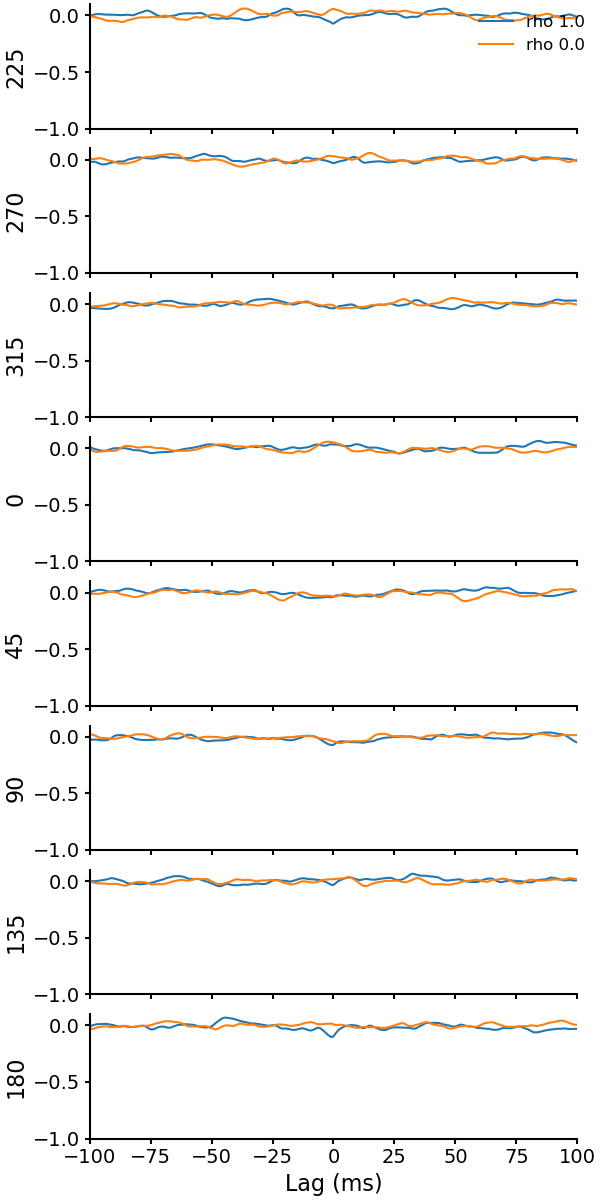

In [17]:
# show_rhos = [0.0, 0.8, 0.9, 0.96, 1.0]
show_rhos = rhos
full_xaxis = np.concatenate([np.flip(xaxis[1:] * -1), xaxis])
dir_residual_corr_fig, dir_residual_corr_ax = plt.subplots(len(dir_labels), sharex=True, sharey=True, figsize=(6, 12))
for i in range(len(dir_labels)):
    for rho in show_rhos:
        lbl = ("rho " + str(rho)) if not i else None
        dir_residual_corr_ax[i].plot(full_xaxis, residual_corr_full_net_avg[rho][i], label=lbl)
    dir_residual_corr_ax[i].set_ylabel(dir_labels[i], fontsize=16)

dir_residual_corr_ax[-1].set_xlim(-100, 100)
dir_residual_corr_ax[-1].set_ylim(-1, 0.1)
dir_residual_corr_ax[-1].set_xlabel("Lag (ms)", fontsize=16)
dir_residual_corr_fig.legend(frameon=False, fontsize=12)
clean_axes(dir_residual_corr_ax, ticksize=14, spine_width=1.5)
dir_residual_corr_fig.set_layout_engine("compressed")

for ext in [".png", ".svg"]:
    name = "directional_residual_xcorr" + ext 
    dir_residual_corr_fig.savefig(os.path.join(fig_path, name), bbox_inches="tight")

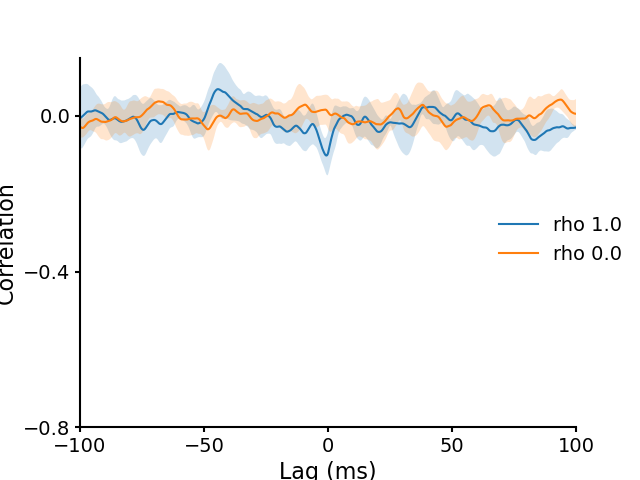

In [18]:
# show_rhos = [0.0, 0.8, 0.9, 0.96, 1.0]
show_rhos = rhos

null_residual_corr_fig, null_residual_corr_ax = plt.subplots(1)
for rho in show_rhos:
    null_residual_corr_ax.fill_between(
        full_xaxis, 
        residual_corr_full_net_avg[rho][null_idx] + residual_corr_full_net_std[rho][null_idx], 
        residual_corr_full_net_avg[rho][null_idx] - residual_corr_full_net_std[rho][null_idx], 
        alpha=0.2,
    )
    null_residual_corr_ax.plot(full_xaxis, residual_corr_full_net_avg[rho][null_idx], label="rho " + str(rho))
    
null_residual_corr_ax.set_xlim(-100, 100)
null_residual_corr_ax.set_ylim(-0.8, 0.15)
null_residual_corr_ax.set_xticks([-100, -50, 0, 50, 100])
null_residual_corr_ax.set_yticks([-0.8, -0.4, 0.])
null_residual_corr_ax.set_xlabel("Lag (ms)", fontsize=16)
null_residual_corr_ax.set_ylabel("Correlation", fontsize=16)
null_residual_corr_fig.legend(frameon=False, fontsize=14, loc="center right")
clean_axes(null_residual_corr_ax, ticksize=14, spine_width=1.5)

for ext in [".png", ".svg"]:
    name = "null_residual_xcorr" + ext 
    null_residual_corr_fig.savefig(os.path.join(fig_path, name), bbox_inches="tight")

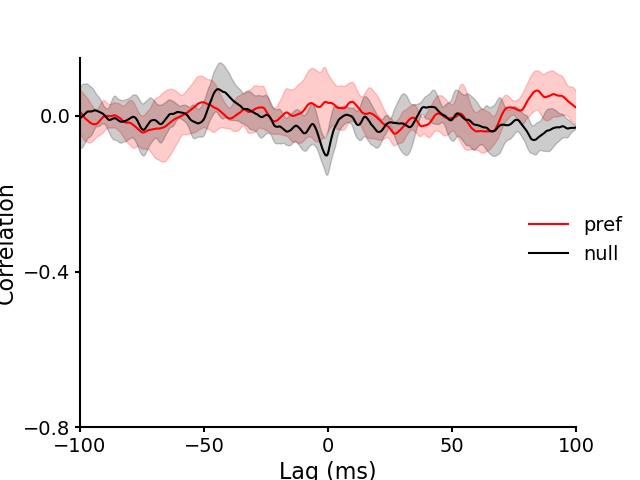

In [19]:
rho = 1
# rho = 0.96
pn_residual_corr_fig, pn_residual_corr_ax = plt.subplots(1)
pn_residual_corr_ax.fill_between(
    full_xaxis, 
    residual_corr_full_net_avg[rho][pref_idx] + residual_corr_full_net_std[rho][pref_idx], 
    residual_corr_full_net_avg[rho][pref_idx] - residual_corr_full_net_std[rho][pref_idx], 
    color="red",
    alpha=0.2,
)
pn_residual_corr_ax.plot(full_xaxis, residual_corr_full_net_avg[rho][pref_idx], c="red", label="pref")
pn_residual_corr_ax.fill_between(
    full_xaxis, 
    residual_corr_full_net_avg[rho][null_idx] + residual_corr_full_net_std[rho][null_idx], 
    residual_corr_full_net_avg[rho][null_idx] - residual_corr_full_net_std[rho][null_idx], 
    color="black",
    alpha=0.2,
)
pn_residual_corr_ax.plot(full_xaxis, residual_corr_full_net_avg[rho][null_idx], c="black", label="null")
    
pn_residual_corr_ax.set_xlim(-100, 100)
pn_residual_corr_ax.set_ylim(-0.8, 0.15)
pn_residual_corr_ax.set_xticks([-100, -50, 0, 50, 100])
pn_residual_corr_ax.set_yticks([-0.8, -0.4, 0.])
pn_residual_corr_ax.set_xlabel("Lag (ms)", fontsize=16)
pn_residual_corr_ax.set_ylabel("Correlation", fontsize=16)
pn_residual_corr_fig.legend(frameon=False, fontsize=14, loc="center right")
clean_axes(pn_residual_corr_ax, ticksize=14, spine_width=1.5)

for ext in [".png", ".svg"]:
    name = "pref_null_residual_xcorr_rho" + str(rho).replace(".", "p") + ext 
    pn_residual_corr_fig.savefig(os.path.join(fig_path, name), bbox_inches="tight")

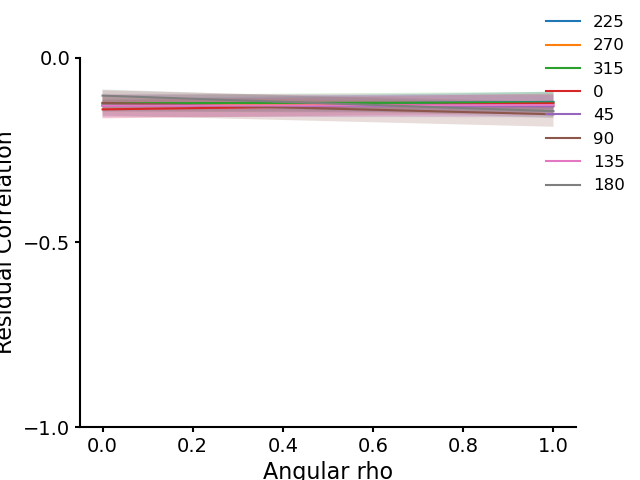

In [20]:
show_stds = True
show_dirs = dir_labels
# show_dirs = [0, 90, 180]
rho_vs_corr_fig, rho_vs_corr_ax = plt.subplots(1)

for angle in show_dirs:
    i = np.argwhere(dir_labels == angle)[0][0]
    corrs = np.array([residual_corr_full_peak_net_avg[r][i] for r in rhos])
    if show_stds:
        corr_stds = np.array([residual_corr_full_peak_net_std[r][i] for r in rhos])
        rho_vs_corr_ax.fill_between(rhos, corrs + corr_stds, corrs - corr_stds, alpha=0.2)
    rho_vs_corr_ax.plot(rhos, corrs, label=dir_labels[i])
    
rho_vs_corr_ax.set_ylim(-1, 0)
rho_vs_corr_ax.set_yticks([-1., -0.5, 0.])
rho_vs_corr_ax.set_xlabel("Angular rho", fontsize=16)
rho_vs_corr_ax.set_ylabel("Residual Correlation", fontsize=16)
rho_vs_corr_fig.legend(frameon=False, fontsize=12)
clean_axes(rho_vs_corr_ax, ticksize=14, spine_width=1.5)

for ext in [".png", ".svg"]:
    rho_vs_corr_fig.savefig(os.path.join(fig_path, "rho_vs_residual_xcorr" + ext), bbox_inches="tight")

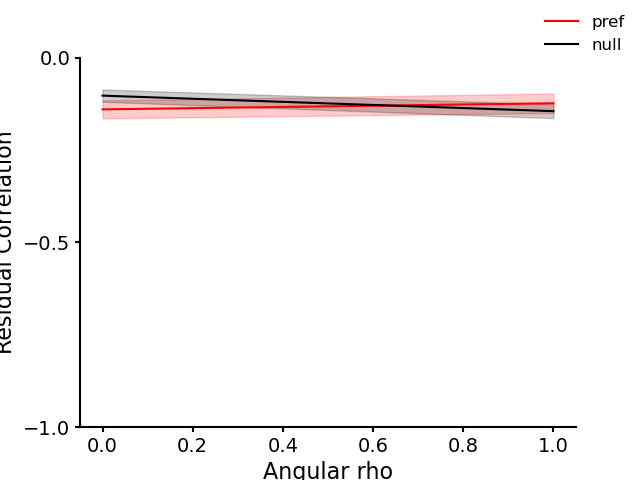

In [21]:
pn_rho_vs_corr_fig, pn_rho_vs_corr_ax = plt.subplots(1)

pref_corrs = np.array([residual_corr_full_peak_net_avg[r][pref_idx] for r in rhos]) 
pref_corr_stds = np.array([residual_corr_full_peak_net_std[r][pref_idx] for r in rhos])
null_corrs = np.array([residual_corr_full_peak_net_avg[r][null_idx] for r in rhos]) 
null_corr_stds = np.array([residual_corr_full_peak_net_std[r][null_idx] for r in rhos])
pn_rho_vs_corr_ax.fill_between(
    rhos, 
    pref_corrs + pref_corr_stds, 
    pref_corrs - pref_corr_stds, 
    color="red",
    alpha=0.2,
)
pn_rho_vs_corr_ax.plot(rhos, pref_corrs, c="red", label="pref")
pn_rho_vs_corr_ax.fill_between(
    rhos, 
    null_corrs + null_corr_stds, 
    null_corrs - null_corr_stds, 
    color="black",
    alpha=0.2,
)
pn_rho_vs_corr_ax.plot(rhos, null_corrs, c="black", label="null")
    
pn_rho_vs_corr_ax.set_ylim(-1, 0)
pn_rho_vs_corr_ax.set_yticks([-1., -0.5, 0.])
pn_rho_vs_corr_ax.set_xlabel("Angular rho", fontsize=16)
pn_rho_vs_corr_ax.set_ylabel("Residual Correlation", fontsize=16)
pn_rho_vs_corr_fig.legend(frameon=False, fontsize=12)
clean_axes(pn_rho_vs_corr_ax, ticksize=14, spine_width=1.5)

for ext in [".png", ".svg"]:
    name = os.path.join(fig_path, "pref_null_rho_vs_residual_xcorr" + ext)
    pn_rho_vs_corr_fig.savefig(name, bbox_inches="tight")